In [1]:
import urllib.request
import zipfile
import numpy as np
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

## STEP 1. Load Dataset

### 어린이,노인남녀,일반남녀 Mel_Spec 이미지로 구성


In [2]:
!pwd

/home/tf2/CNN_Voice_Gender_Age_Classification


In [3]:
base = tf.io.gfile.glob(str('/home/tf2/VGG16/Dataset/train') + '/*/*')
base = tf.random.shuffle(base)
num_samples = len(base)
print('Number of total train examples:', num_samples)

Number of total train examples: 18002


## STEP 2. 전처리 (ImageDataGenerator)

In [4]:
train_dir = '/home/tf2/VGG16/Dataset/train'
test_dir = '/home/tf2/VGG16/Dataset/test'
valid_dir = '/home/tf2/VGG16/Dataset/validation'

In [29]:
training_datagen = ImageDataGenerator(
    rescale=1. / 255,
    # 위의 옵션 값들을 보고 적절히 대입하여 줍니다.
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest', 
    validation_split=0.2
    )

### Training_generator / Validation_generator / Test_generator

In [30]:
training_generator = training_datagen.flow_from_directory(train_dir, 
                                                          batch_size=128,
                                                          target_size=(224,224),
                                                          class_mode='categorical',
                                                          subset='training',
                                                          classes=['kid','med','old']
                                                         )

Found 14400 images belonging to 3 classes.


In [31]:
validation_generator = training_datagen.flow_from_directory(valid_dir, 
                                                          batch_size=128,
                                                          target_size=(224,224),
                                                          class_mode='categorical',
                                                          subset='validation',
                                                          classes=['kid','med','old']
                                                         )

Found 1200 images belonging to 3 classes.


In [32]:
test_generator = training_datagen.flow_from_directory(test_dir, 
                                                          batch_size=128,
                                                          target_size=(224,224),
                                                          class_mode='categorical',
                                                          subset='validation',
                                                          classes=['kid','med','old']
                                                         )

Found 1200 images belonging to 3 classes.


## STEP 3. 시각화

In [33]:
import matplotlib.pyplot as plt

%matplotlib inline

In [34]:
class_map = {
    0: 'kid',
    1: 'med',
    2: 'old'
}

In [35]:
base_dir = '/home/tf2/VGG16/Dataset'

In [36]:
original_datagen = ImageDataGenerator(rescale=1./255)

In [37]:
original_generator = original_datagen.flow_from_directory(base_dir,
                                                          batch_size=128,
                                                          target_size=(224,224),
                                                          class_mode='categorical',
                                                          classes=['test','train','validation']
                                                          )

Found 29999 images belonging to 3 classes.


오리지널 사진 파일
(128, 224, 224, 3) (128, 3)
[0. 1. 0.]


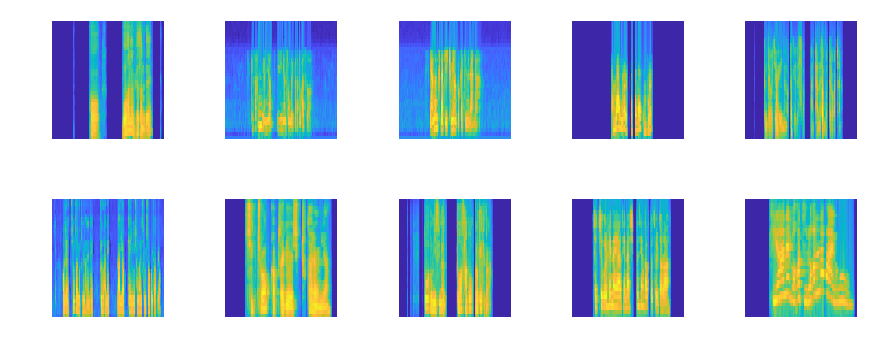

Rescale
(128, 224, 224, 3) (128, 3)
[0. 0. 1.]


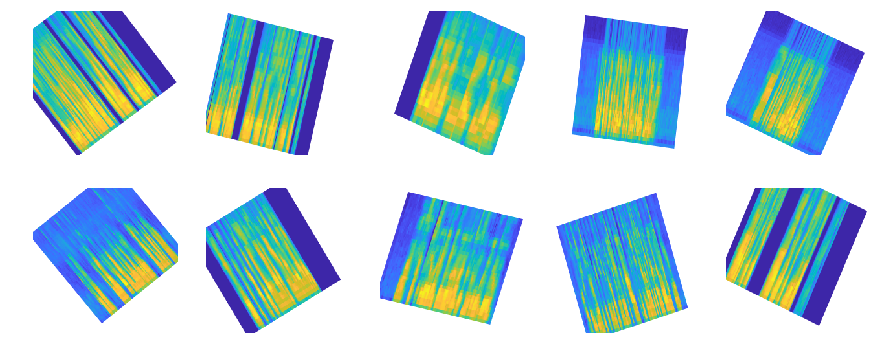

In [38]:
print('오리지널 사진 파일')

for x,y in original_generator:
  print(x.shape, y.shape)
  print(y[0])

  fig, axes = plt.subplots(2,5)
  fig.set_size_inches(15, 6)
  for i in range(10):
    axes[i//5, i%5].imshow(x[i])
    #axes[i//5, i%5].set_title(class_map[int(y[i])], fontsize=15)
    axes[i//5, i%5].axis('off')

  plt.show()
  break

print('Rescale')

for x,y in training_generator:
  print(x.shape, y.shape)
  print(y[0])

  fig, axes = plt.subplots(2,5)
  fig.set_size_inches(15, 6)
  for i in range(10):
    axes[i//5, i%5].imshow(x[i])
    #axes[i//5, i%5].set_title(class_map[int(y[i])], fontsize=15)
    axes[i//5, i%5].axis('off')

  plt.show()
  break

### Conv2d 거친 후 이미지 시각화해보기

In [39]:
for x, y in original_generator:
  pic = x[:5]
  break
pic.shape

(5, 224, 224, 3)

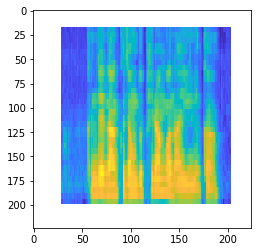

In [40]:
#시각화 해보기
plt.imshow(pic[0])

In [41]:
conv2d = Conv2D(64, (3, 3), input_shape=(224, 224, 3))
conv2d_activation = Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3))

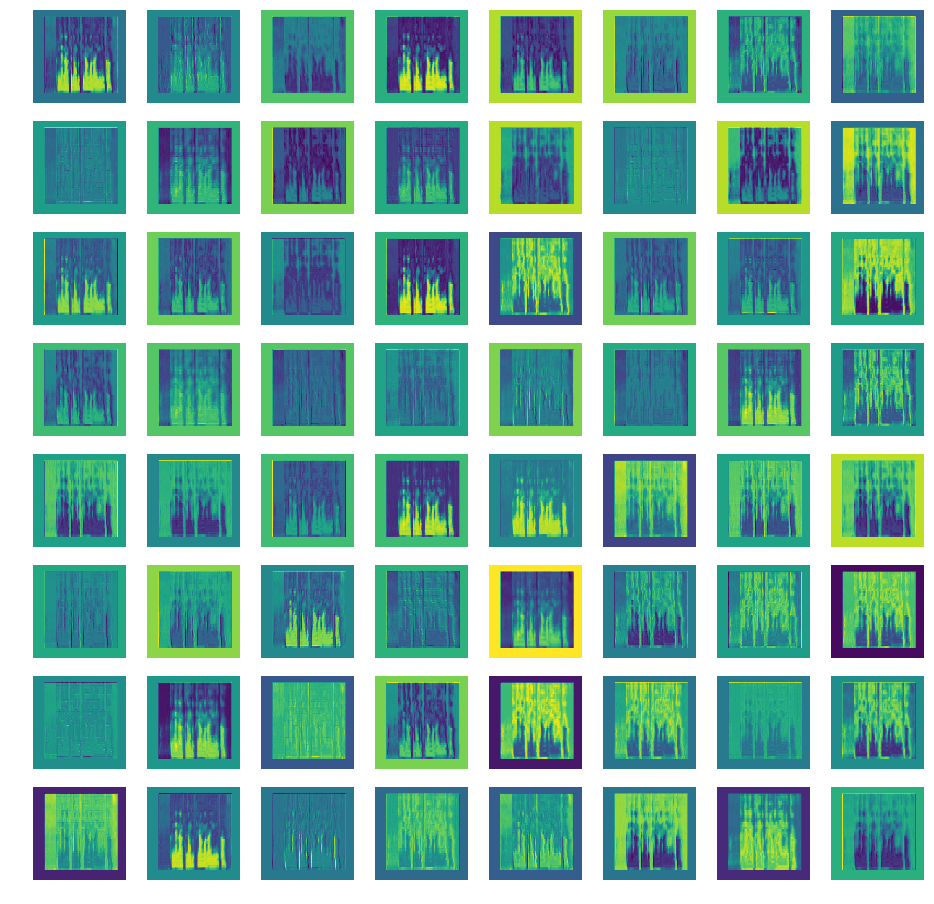

In [42]:
fig, axes = plt.subplots(8,8)
fig.set_size_inches(16, 16)
for i in range(64):
  axes[i//8, i%8].imshow(conv2d(pic)[0,:,:,i])
  axes[i//8, i%8].axis('off')

## STEP 3. 모델 정의 (Sequential)

In [43]:
model = Sequential([
    
    Conv2D(32, (3, 3), activation='relu',input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    # 2D -> 1D로 변환을 위하여 Flatten 합니다.
    Flatten(),
    # 과적합 방지를 위하여 Dropout을 적용합니다.
    Dropout(0.5),
    # Dense
    Dense(512, activation='relu'),
    # Classification을 위한 Softmax 
    # 출력층의 갯수는 클래스의 갯수와 동일하게 맞춰줍니다 (3개), activation도 잊지마세요!
    Dense(3, activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        3

## STEP 4. 컴파일 (compile)

In [44]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

## STEP 5. ModelCheckpoint

`val_loss` 기준으로 epoch 마다 최적의 모델을 저장하기 위하여, ModelCheckpoint를 만듭니다.
* `checkpoint_path`는 모델이 저장될 파일 명을 설정합니다.
* `ModelCheckpoint`을 선언하고, 적절한 옵션 값을 지정합니다.

In [45]:
checkpoint_path = "adam_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

## STEP 6. 학습 (fit)

In [46]:
epochs=20
history = model.fit(training_generator,
                    validation_data=(validation_generator),
                    epochs=epochs,
                    callbacks=[checkpoint]
                    )

Epoch 1/20
113/113 [==============================] - 511s 5s/step - loss: 0.8911 - acc: 0.4930 - val_loss: 1.2467 - val_acc: 0.4800

Epoch 00001: val_loss improved from inf to 1.24669, saving model to adam_checkpoint.ckpt
Epoch 2/20
113/113 [==============================] - 507s 4s/step - loss: 0.5949 - acc: 0.6291 - val_loss: 1.0682 - val_acc: 0.3967

Epoch 00002: val_loss improved from 1.24669 to 1.06822, saving model to adam_checkpoint.ckpt
Epoch 3/20
113/113 [==============================] - 503s 4s/step - loss: 0.5541 - acc: 0.6444 - val_loss: 1.7669 - val_acc: 0.5283

Epoch 00003: val_loss did not improve from 1.06822
Epoch 4/20
113/113 [==============================] - 529s 5s/step - loss: 0.5177 - acc: 0.6510 - val_loss: 1.6072 - val_acc: 0.4242

Epoch 00004: val_loss did not improve from 1.06822
Epoch 5/20
113/113 [==============================] - 507s 4s/step - loss: 0.5175 - acc: 0.6492 - val_loss: 1.7365 - val_acc: 0.3442

Epoch 00005: val_loss did not improve from 1.0

## STEP 7. 학습 완료 후 Load Weights (ModelCheckpoint)

In [96]:
model.load_weights(checkpoint_path)

In [97]:
result_valid = model.evaluate(validation_generator)
print("valid_loss, valid_accuracy", result_valid)

47/47 [==============================] - 93s 2s/step - loss: 0.4949 - acc: 0.6467
valid_loss, valid_accuracy [0.49492427706718445, 0.6466666460037231]


In [98]:
result_test = model.evaluate(test_generator)
print("test_loss, test_accuracy", result_test)

47/47 [==============================] - 92s 2s/step - loss: 2.2533 - acc: 0.3827
test_loss, test_accuracy [2.253330707550049, 0.382666677236557]


In [99]:
import matplotlib.pyplot as plt

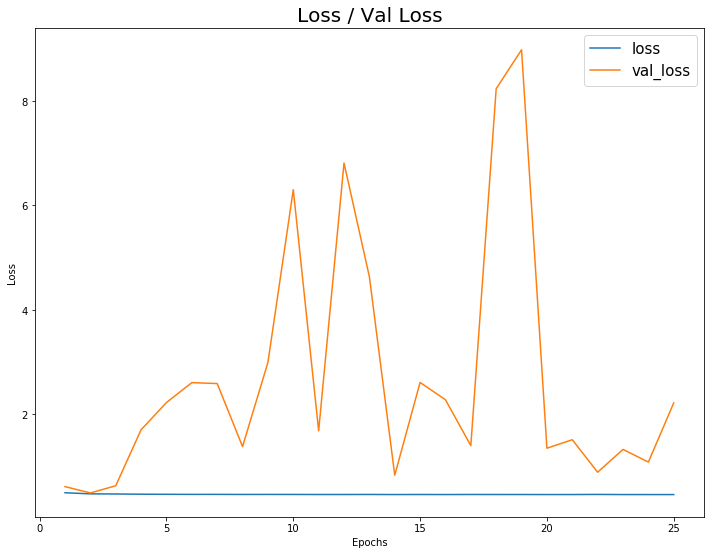

In [100]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['loss'])
plt.plot(np.arange(1, epochs+1), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], fontsize=15)
plt.show()

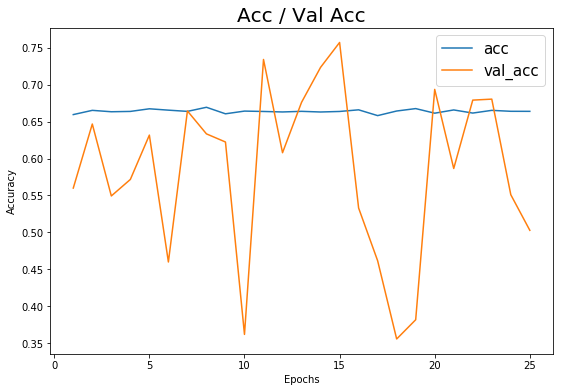

In [101]:
plt.figure(figsize=(9, 6))
plt.plot(np.arange(1, epochs+1), history.history['acc'])
plt.plot(np.arange(1, epochs+1), history.history['val_acc'])
plt.title('Acc / Val Acc', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['acc', 'val_acc'], fontsize=15)
plt.show()